# KORONAVIRUS

U jeku nove epidemije naše su misli cijeli dan, svaki dan, usmjerene na nove vijesti o stanju u državi i svijetu, broju zaraženih, oporavljenih i preminulih od nove bolesti. Budući da su svi ti podatci danas lako dostupni (a medicina je iznimno zanimljiva za proučavanje s matematičke točke gledišta), u ovom ćemo radu promatrati i analizirati te podatke.

## Što je koronavirus?

Par činjenica unijeti, ne previše, ali ipak da znamo što je.

## Analiza podataka

Podatci su preuzeti sa stranice https://data.europa.eu/euodp/hr/data/dataset/covid-19-coronavirus-data i spremljeni u datoteku imena (zasad) `preuzmi.csv`. <br><br>
Podatci u tablici su sljedeći:<br><br>
```
    1. dateRep = promatrani datum u formatu 'dd/mm/gggg'
    2. day = broj dana u promatranom datumu
    3. month = broj mjeseca u promatranom datumu
    4. year = broj godine u promatranom datumu
    5. cases = broj novozaraženih na promatrani dan
    5. deaths = broj preminulih na promatrani dan
    6. countriesAndTerritories = naziv države
    7. geoId = iso kod države (alpha 2)
    8. countryterritoryCode = iso kod države (alpha 3)
    9. popData2018 = ukupan broj populacije iz 2018. za promatranu državu
```
<br>
Prije nego što krenemo prikazivati tablice i analizirati podatke, prvo želimo tablicu <i>srediti</i>. Vidimo odmah da u ovoj tablici ima redundancija (datumi) i nama nebitnih podataka (iso kodovi) pa ćemo prije svega uključiti potrebne biblioteke i riješiti se tih problema (pa usto i preimenovati preostajeće podatke u nešto <i>ljepše</i>).

In [1]:
import numpy as np
import pandas as pd
import datetime as dtt

def izdvoji_drzavu(drzava):
    return data[data['Country'] == drzava]
#nije potrebno pisati ovu funkciju, ali s njom ne moramo konstantno pisati istu, iscrpljujuće dugu liniju koda

data = pd.read_csv('preuzmi.csv', encoding='utf-8')
data = data.rename(columns={'dateRep': 'Date', 'cases': 'Cases', 'deaths': 'Deaths', 'countriesAndTerritories': 'Country', 'popData2018': 'Population'})

dani = np.array(izdvoji_drzavu('China')['day'])[::-1]
mjeseci = np.array(izdvoji_drzavu('China')['month'])[::-1]
godine = np.array(izdvoji_drzavu('China')['year'])[::-1]
datumi = np.array(izdvoji_drzavu('China')['Date'])[::-1]
dat_rj = {}
for i in range(0, dani.shape[0]):
    dat_rj[datumi[i]] = dtt.datetime(godine[i], mjeseci[i], dani[i])
data.replace({'Date': dat_rj}, inplace = True)
del data['day'], data['month'], data['year'], data['geoId'], data['countryterritoryCode']

In [2]:
data.head()

,Date,Cases,Deaths,Country,Population
0,2020-04-12,34,3,Afghanistan,37172386.0
1,2020-04-11,37,0,Afghanistan,37172386.0
2,2020-04-10,61,1,Afghanistan,37172386.0
3,2020-04-09,56,3,Afghanistan,37172386.0
4,2020-04-08,30,4,Afghanistan,37172386.0


Sad možemo pogledati grafički prikaz razvoja epidemije.<br>
Prije svega ćemo prikazati kretanje broja zaraženih:

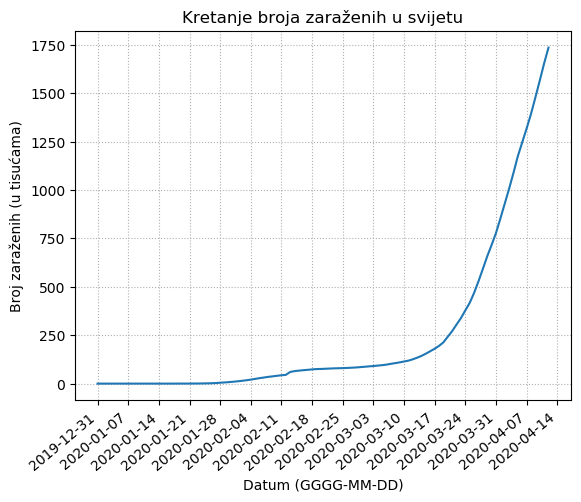

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.max_open_warning'] = 50
%matplotlib agg

def ukupno_dnevno_stanje(argument):
    lista=[]
    suma = 0
    for datum in izdvoji_drzavu('China')['Date'][::-1]:
        for broj in data[data['Date']==datum][argument]:
            suma += broj
        lista.append(suma)
    return lista

def pokazi_stanje_u_svijetu(argument):
    base =dtt.datetime(2019, 12, 31)
    dates2 = np.array([base + dtt.timedelta(days = i*7) for i in range (0, 16)])
    fig, ax = plt.subplots()
    ax.plot(np.array(izdvoji_drzavu('China')['Date'])[::-1], np.array(ukupno_dnevno_stanje(argument))/1000)
    if (argument == 'Cases'):
        ax.set_title('Kretanje broja zaraženih u svijetu')
        ax.set_ylabel('Broj zaraženih (u tisućama)')
    elif (argument == 'Deaths'):
        ax.set_title('Kretanje broja preminulih u svijetu')
        ax.set_ylabel('Broj preminulih (u tisućama)')
    ax.set_xlabel('Datum (GGGG-MM-DD)')
    plt.xticks(rotation=40, ha='right')
    ax.set_xticks(dates2)
    plt.grid(linestyle = ':')
    return fig

pokazi_stanje_u_svijetu('Cases')

Safa pogledajmo i kretanje broja preminulih:

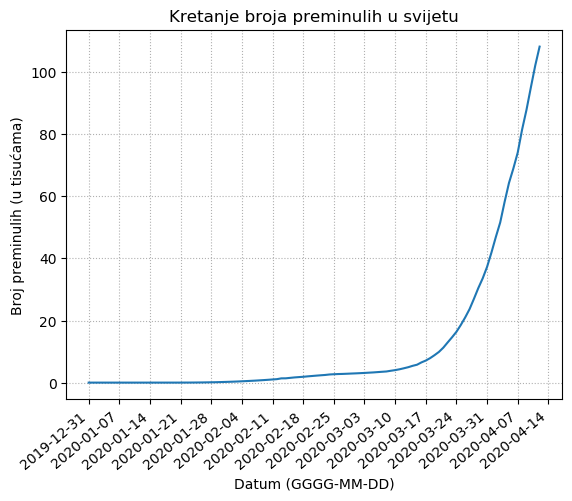

In [4]:
pokazi_stanje_u_svijetu('Deaths')

Želimo (uredno) prikazati kretanje broja zaraženih i preminulih od virusa i po državama, ne samo u svijetu.

In [5]:
def lista_dnevno_stanje(drzava, argument):
    lista = []
    i=-1
    for dnevno_stanje in np.array(izdvoji_drzavu(drzava)[argument])[::-1]:
        if (i==-1): lista.append(int(dnevno_stanje))
        else: lista.append(int(dnevno_stanje)+lista[i])
        i +=1
    return lista
#pomoćna funkcija koja nam vraća listu podataka
        #naime, zgodna nam je, jer se u našoj tablici data u stupcu Cases nalaze podatci o broju novozaraženih toga dana
        #a mi želimo pratiti kontinuirani rast

def prikaz_kontinuiranog_stanja(drzava, argument):
    dates = np.array(izdvoji_drzavu(drzava)['Date'])[::-1]
    i = 0
    while(np.array(izdvoji_drzavu(drzava)[izdvoji_drzavu(drzava)['Date']==dates[i]][argument])[0]==0): i += 1
    if (i > 2): i -= 2
    #ne želimo imati puno 'nula', pa zato krećemo prikazivati podatke od par dana prije pojave prvog oboljelog
    n = dates[i:].shape[0]//10
    base = dates[i]
    dates2 = np.array([base + np.timedelta64(i*n, 'D') for i in range (0, 12)])
    #također ne želimo da nam se prikaže apsolutno svaki datum jer je to nepregledno
    fig, ax = plt.subplots()
    ax.plot(dates[i:], lista_dnevno_stanje(drzava, argument)[i:])
    plt.xticks(rotation=40, ha='right')
    ax.set_xticks(dates2)
    if (argument == 'Cases'):
        ax.set_title('Kretanje broja zaraženih u državi: ' + drzava)
        ax.set_ylabel('Broj zaraženih')
    elif (argument == 'Deaths'):
        ax.set_title('Kretanje broja preminulih u državi: ' + drzava)
        ax.set_ylabel('Broj preminulih')
    ax.set_xlabel('Datum (GGGG-MM-DD)')
    plt.grid(linestyle = ':')
    return fig

Za primjer, evo grafičkog prikaza podataka u SAD-u:

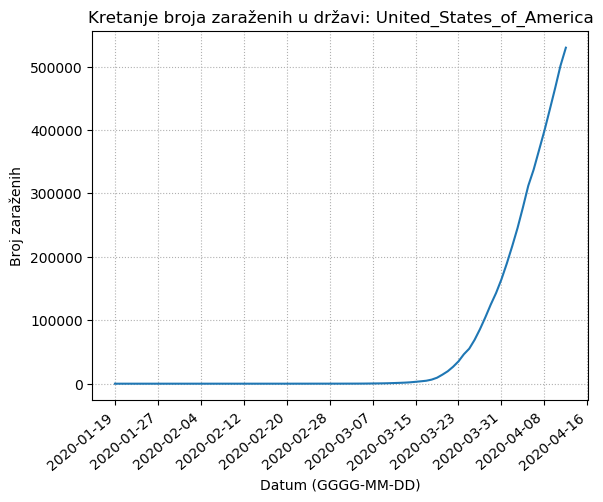

In [6]:
prikaz_kontinuiranog_stanja('United_States_of_America', 'Cases')

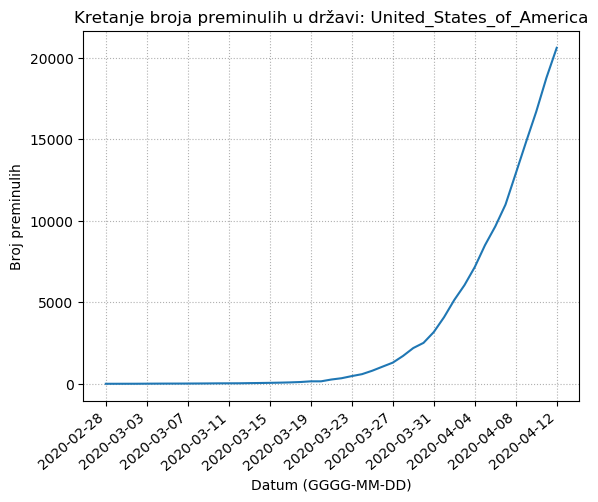

In [7]:
prikaz_kontinuiranog_stanja('United_States_of_America', 'Deaths')

Također nam je korisno uspoređivati podatke u raznim državama:

In [8]:
def pripremi_podatke(drzava, argument):
    dates = np.array(izdvoji_drzavu(drzava)['Date'])[::-1]
    n = dates.shape[0]//10
    base = dates[0]
    dates2 = np.array([base + np.timedelta64(i*n, 'D') for i in range (0, 12)])
    return [dates, dates2]
#još jedna pomoćna funkcija za bolju organizaciju podataka

def usporedba(lista, argument):
    brojevi = np.array([izdvoji_drzavu(drzava)[izdvoji_drzavu(drzava)['Cases']>=0].shape[0] for drzava in lista])
    broj = brojevi.max()
    i = 0
    for temp in brojevi:
        if (broj == temp): break;
        i += 1
    datumi = pripremi_podatke(lista[i], argument)
    fig, ax = plt.subplots()
    duljina = datumi[0].shape[0]
    for j in range (0, len(lista)):
        nova = lista_dnevno_stanje(lista[j], argument)[::-1]
        while (len(nova) < duljina): nova.append(0)
        ax.plot(datumi[0], nova[::-1]/(np.array(izdvoji_drzavu(lista[j])['Population'])[0]/100), label = lista[j])
    plt.xticks(rotation=40, ha='right')
    ax.set_xticks(datumi[1])
    ax.legend(loc = 'best')
    if (argument == 'Cases'): 
        ax.set_title('Usporedba kretanja broja zaraženih')
        ax.set_ylabel('Udio zaraženih (%)')
    elif (argument == 'Deaths'): 
        ax.set_title('Usporedba kretanja broja preminulih')
        ax.set_ylabel('Udio preminulih (%)')
    ax.set_xlabel('Datum (GGGG-MM-DD)')
    plt.grid(linestyle = ':')
    return fig

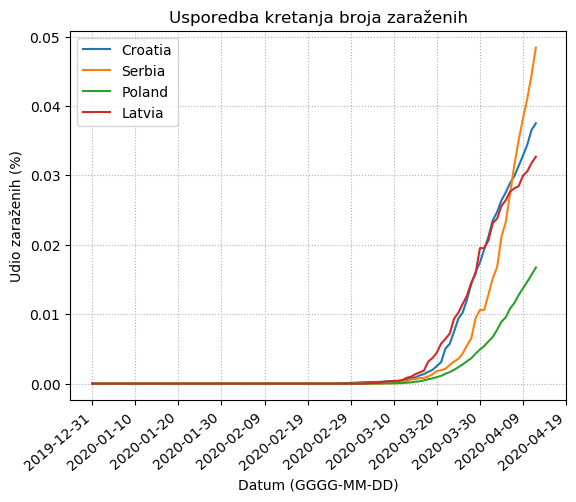

In [9]:
usporedba(['Croatia', 'Serbia', 'Poland', 'Latvia'], 'Cases')

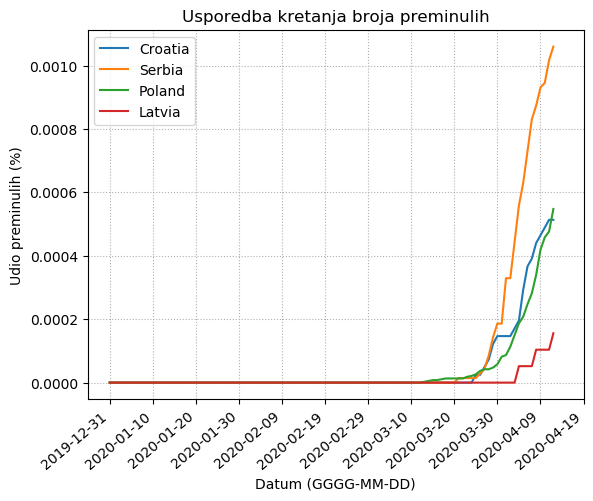

In [10]:
usporedba(['Croatia', 'Serbia', 'Poland', 'Latvia'], 'Deaths')

## Predviđanje daljnjeg razvoja epidemije

Naravno, nas ne zanima isključivo trenutno stanje, već nas zanima možemo li <i>predvidjeti</i> daljnji tijek ove epidemije?<br>
Odgovor: <b>linearna regresija</b>.<br><br>
<i>Slijedi pojašnjenje što je linearna regresija i metoda najmanjih kvadrata i na koji način to ovdje koristimo, nadodat ću tekst naknadno...</i><br><br>
Maločas navedenom metodom možemo procijeniti mogući tijek epidemije (na primjer, za Hrvatsku): <br><br>
Ovdje imamo dva očita problema korištenja linearne regresije:
<lu>
    <li>U stvarnosti je rast rijetko gdje doista eksponencijalan, prije svega jer su nadležne vlasti reagirale relativno pravodobno i učile na dosadašnjim greškama ostalih nacija (jedan relativno dobar primjer je dakako i Hrvatska).</li>
    <li>Na mjestima gdje rast u početku i jest eksponencijalan, obično se on vrlo brzo stavi pod kontrolu pa nam funkcija dobivena ovom metodom više puno i ne koristi (npr. trenutno nam nema smisla na ovaj način proučavati podatke u Kini).</li>
</lu>

In [11]:
import statsmodels.api as sm

def pomocni_ln(broj):
    if (broj == 0): return 0
    else: return float(np.log(broj))

lnn = np.vectorize(pomocni_ln, otypes=[np.float])

def vrati_procjenu(a, b):
    return lambda x: (np.e**a)*((np.e**b)**x)

def podatci_graf_regresija(drzava):
    dates = np.array(izdvoji_drzavu(drzava)['Date'])[::-1]
    broj_dana = 0
    while(np.array(izdvoji_drzavu(drzava)[izdvoji_drzavu(drzava)['Date']<=dates[broj_dana]]['Cases']).sum()==0):
        broj_dana += 1
    if (broj_dana > 2): broj_dana -= 2
    brojac_dana = [i for i in range(0, dates.shape[0]-broj_dana)]
    brojac_dana2 = sm.add_constant(brojac_dana)
    zaraza = lnn(np.array(lista_dnevno_stanje(drzava, 'Cases'))[broj_dana:])
    model = sm.OLS(zaraza, brojac_dana2)
    rez = model.fit()
    print(rez.summary())
    funkcija = vrati_procjenu(rez.params[0], rez.params[1])
    n = dates[broj_dana:].shape[0]//10
    base = dates[broj_dana]
    dates2 = np.array([base + np.timedelta64(i*n, 'D') for i in range (0, 12)])
    #također ne želimo da nam se prikaže apsolutno svaki datum jer je to nepregledno
    fig, ax = plt.subplots()
    ax.plot(dates[broj_dana:], lista_dnevno_stanje(drzava, 'Cases')[broj_dana:], label = 'Pravi brojevi')
    ax.plot(dates[broj_dana:], np.vectorize(funkcija)(brojac_dana), label = 'Procjena')
    plt.xticks(rotation=40, ha='right')
    ax.set_xticks(dates2)
    ax.set_title('Stvarni brojevi i dobiveni pomoću OLS u državi: ' + drzava)
    ax.set_ylabel('Broj zaraženih')
    ax.set_xlabel('Datum (GGGG-MM-DD)')
    ax.legend(loc = 'best')
    plt.grid(linestyle = ':')
    return [fig, funkcija]

Primjer kada nam linearna regresija i može reći kako se podatci mogu dalje kretati jest SAD, jer je rast ondje i dalje eksponencijalan:

In [13]:
podatci_SAD = podatci_graf_regresija('United_States_of_America')
funkcija_SAD = podatci_SAD[1]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     1596.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           5.66e-56
Time:                        20:05:16   Log-Likelihood:                -116.31
No. Observations:                  85   AIC:                             236.6
Df Residuals:                      83   BIC:                             241.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2148      0.207     -5.872      0.0

<i>Slijedi interpretacija dobivenih podataka...</i><br><br>
Pogledajmo i grafički prikaz stvarnih podataka i dobivenih ovom metodom:

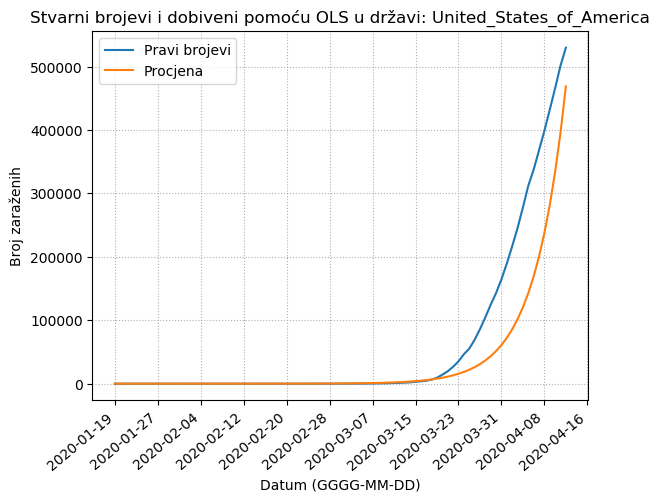

In [14]:
podatci_SAD[0]

Sad možemo i procijeniti mogući broj zaraženih na određeni dan; na primjer, broj zaraženih dana 20. travnja 2020. mogao bi biti $1825824$.

In [15]:
int(round(funkcija_SAD((dtt.datetime(2020, 4, 20)-dtt.datetime(2020, 1, 19)).days)))

1825824

Kao što sam naveo prije, u Hrvatskoj nam ova metoda ne pruža mnogo korisnih podataka jer rast nije eksponencijalan. Jasno vidimo da stoga ovaj rezultat nije egzaktan, pa niti daljnje procjene ne možemo prihvatiti s nekom pouzdanošću.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     1154.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           3.28e-33
Time:                        20:06:05   Log-Likelihood:                -28.481
No. Observations:                  46   AIC:                             60.96
Df Residuals:                      44   BIC:                             64.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5737      0.133      4.303      0.0

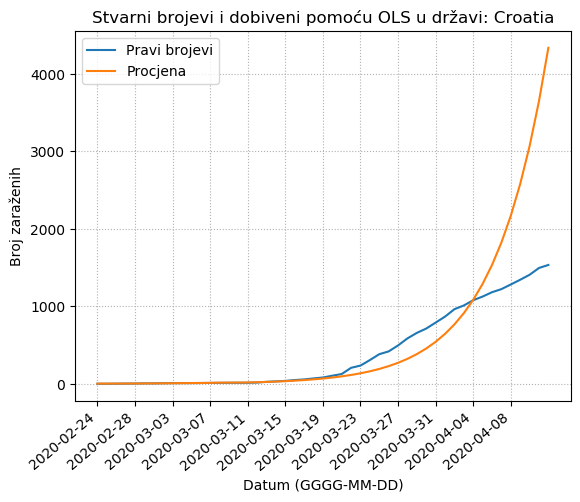

In [16]:
podatci_RH = podatci_graf_regresija('Croatia')
funkcija_RH = podatci_RH[1]
podatci_RH[0]

Za primjer, ova nam procjena kaže da bismo za sva dana, 14. travnja 2020. trebali imati čak $6136$ zaraženih, što je vrlo malo vjerojatan scenarij:

In [18]:
int(round(funkcija_RH((dtt.datetime(2020, 4, 14)-dtt.datetime(2020, 2, 27)).days)))

6136

## Epidemiološki modeli

Ideja za nastavak rada bi bila proučiti relevantne epidemiološke modele za infektivne bolesti.<br>
Modeli se temelje na pretpostavci da imamo tri grupe ljudi:<br><br>
<lu>
    <li>oni koji su podložni bolesti (<i>susceptible</i>)</li>
    <li>širitelji zaraze (<i>infectious</i>)</li>
    <li>oporavljeni (<i>recovered</i>)</li>
</lu><br><br>
Ovisno o mogućnosti prijelaza imamo dva osnovna modela (koja bismo htjeli promatrati):<br><br>
<lu>
    <li> SIR - mogući su prijelazi iz podložnog bolesti u širitelj zaraze, te iz širitelja zaraze u oporavljenog, ali je glavna pretpostavka da se ljudi koji se oporave više ne mogu zaraziti</li>
    <li> SIRS - za razliku od SIR modela, ovdje se pretpostavlja da ljudi nakon što se oporave mogu opet biti podložni zarazi</li>
</lu>

<b>NAPOMENE I IDEJE</b>:<br><br>
<lu>
    <li>Paziti da ovo doista bude priča, a ne samo crtanje lijepih grafova u raznim bojama!</li>
    <li>Sve dosadašnje sekcije nadopuniti konkretnim tekstom i pojašnjenjima što se zapravo događa i što radimo.</li>
    <li>Bilo bi zgodno prilagoditi dosadašnje funkcije tako da nemamo razdvojeni prikaz broja zaraženih i preminulih nego da ta dva grafa budu <i>side-by-side</i>.</li>
    <li>Mogućnost ubacivanja histograma koji bi prikazivao broj novozaraženih po danima.</li>
    <li>Možda kakav 3D graf? Ili animacija? </li>
    <li>Poseban fokus staviti na Hrvatsku i njezine brojke. Prikupiti dodatne podatke o kretanju broja oporavljenih (tj. stranice koronavirus.hr) i prikazati ih.</li>
    <li>Nadalje razviti sekciju o epidemiološkim modelima.</li>
    <li>Urediti kod: prilagoditi imena varijabli (da nemamo bilingvalne nazive), riješiti redundancije u kodu (<u>a ima ih</u>) uvođenjem još nekih pomoćnih funkcija. </li>
</lu>